In [31]:
import math
import numpy as np
from numpy import nan
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import random
import statistics as st


# Changri Nup Lapse rate

In [13]:
df_AWS_5360_30_T = pd.read_csv(r'F:\North_Changri_Nup\AWS(5360)_30_T_2014-2015.csv')
half_hourly_t = list(df_AWS_5360_30_T['Tair (5360)'])
hourly_t = []
for x in range(0, len(half_hourly_t), 2):
    chunk = half_hourly_t[x:x + 2]
    hourly_t.append(sum(chunk)/len(chunk))
Julian_day = []
n = 363
for i in range(n):
    Julian_day.append(i+1)
    
continuous_day = []

for i in Julian_day:
    x = 1
    while x<25:
        continuous_day.append(i+x/24-0.0001)
        x +=1
df_AWS_5360_60_T = pd.DataFrame({'Julian Day': continuous_day, 'Tair (5360)': hourly_t})
df_AWS_5360_60_T.to_csv(r'F:\North_Changri_Nup\AWS(5360)_60_T_2014-2015.csv')
df_CN_t_LR = pd.read_csv(r'F:\North_Changri_Nup\AWS(5360)_60_T_LR_2014-2015.csv')
julian_days_hourly_CN = df_CN_t_LR['Julian Day'] - 31
Lapse_rate_CN = df_CN_t_LR['Lapse_rate (Era5Land)']
df_CN_t_LR.head()

,Julian Day,Tair (5360),Lapse_rate (Era5Land)
0,1.041567,-5.81930,7.053588
1,1.083233,-5.54615,7.565200
2,1.124900,-5.03335,7.817605
3,1.166567,-3.01885,6.742015
4,1.208233,-4.63410,6.729406


# Satopanth Lapse Rate

In [14]:
fhand_L6_t_lapserate_day = open('C:\\Users\\Abhilash Mittal\\Desktop\\Era5land_lr_sp.txt')
Sp_lapse_rate_60 = [] # in C/km
for line in fhand_L6_t_lapserate_day:
    Sp_lapse_rate_60.append(float(line.split()[0]))
    

Sp_Julian_day = [] # hourly Julian day
for i in np.arange(152, 346, 1/24):
    Sp_Julian_day.append(i)
df_sp_lapseRate = pd.DataFrame({'Julian Day': Sp_Julian_day, 'Lapse Rate C/km': Sp_lapse_rate_60})
julian_days_hourly_SP = df_sp_lapseRate['Julian Day']
df_sp_lapseRate

,Julian Day,Lapse Rate C/km
0,152.000000,5.396286
1,152.041667,5.428063
2,152.083333,6.223461
3,152.125000,6.571787
4,152.166667,6.748093
...,...,...
4651,345.791667,5.834453
4652,345.833333,5.639659
4653,345.875000,5.724182
4654,345.916667,5.589166


In [15]:
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 150

# Moving Average

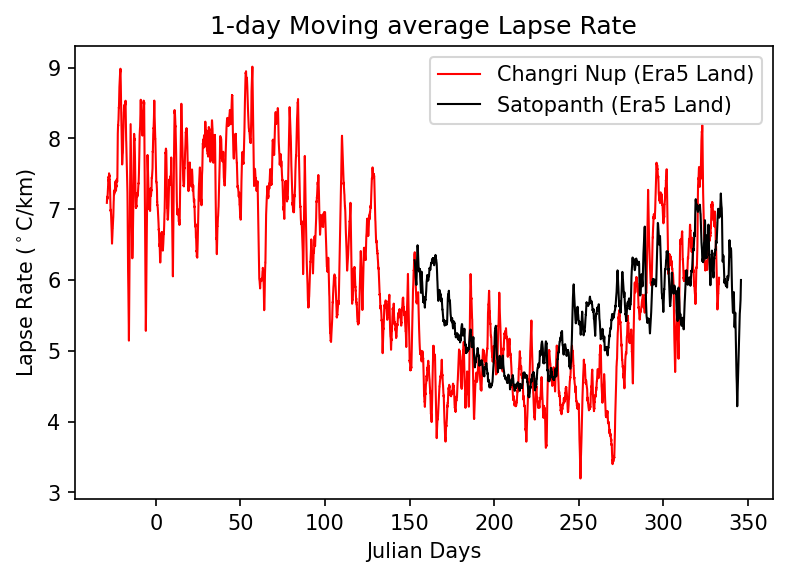

CN 6.064536283423505
SP 5.50273211240725


In [16]:
day_for_ave_lapserate = 1
window_size = int(day_for_ave_lapserate*24)

#Moving average for Changri Nup
numbers_series = pd.Series(df_CN_t_LR['Lapse_rate (Era5Land)'])
windows = numbers_series.rolling(window_size)
moving_averages = windows.mean()

moving_averages_list = moving_averages.tolist()
without_nans_lr = moving_averages_list[window_size - 1:]

#Moving average for Satopanth
numbers_series_sp = pd.Series(df_sp_lapseRate['Lapse Rate C/km'])
windows_sp = numbers_series_sp.rolling(window_size)
moving_averages_sp = windows_sp.mean()

moving_averages_list_sp = moving_averages_sp.tolist()
without_nans_lr_sp = moving_averages_list_sp[window_size - 1:]


plt.plot(julian_days_hourly_CN[window_size-1:], without_nans_lr, 'r', label='Changri Nup (Era5 Land)', linewidth = 1)
plt.plot(julian_days_hourly_SP[window_size-1:], without_nans_lr_sp,  'k', label='Satopanth (Era5 Land)', linewidth = 1)


degree_sign = u"\N{DEGREE SIGN}"
plt.xlabel("Julian Days")
plt.ylabel("Lapse Rate ($^\circ$C/km)")
plt.title("1-day Moving average Lapse Rate")
plt.legend()
plt.show()
print('CN', sum(without_nans_lr)/len(without_nans_lr))
print('SP', sum(without_nans_lr_sp)/len(without_nans_lr_sp))

# Calculating PDD For Changri Nup Stake data

In [22]:
df_Stake_ablation = pd.read_csv(r'F:\North_Changri_Nup\Comparison\Stake_Ablation_Data.csv')
df_Stake_ablation.head()

,Stake Name,jd1,jd2,Debris Thickness,Time Period,Elevation,Obs_days,MB (cm w.e.),time_period
0,CNBL21âˆ’14,114,197,6.0,MB avr15_jul15,5471.842,83,97.25,2
1,CNBL22âˆ’14,-29,113,33.0,MB nov14_avr15,5471.822,145,3.60,1
2,CNBL22âˆ’14,114,197,33.0,MB avr15_jul15,5471.822,83,63.00,2
3,CNBL22âˆ’14,198,229,33.0,MB jul15_aug15,5471.822,31,42.30,3
4,CNBL23âˆ’14,-29,113,11.0,MB nov14_avr15,5471.604,145,3.60,1


In [23]:
day = julian_days_hourly_CN
hourly_T_CN = df_CN_t_LR['Tair (5360)']

def ddf(range_days, elevation, melt):
    temp = []
    for time_step, lr, temp_at_aws in zip(day[window_size:], without_nans_lr[1:], hourly_T_CN[window_size:]):
        if int(time_step) in range_days:
            temp.append((lr / 1000) * (5360 - elevation) + temp_at_aws)

    # now for pdd calculation I need positive values from  x hourly_temp list
    PDD = sum([x for x in temp if x > 0])/24    # divided by 24 because delta t is 1/24
    return PDD

pdd = []

for starting_day, last_day, z, m in zip(df_Stake_ablation['jd1'],df_Stake_ablation['jd2'], df_Stake_ablation['Elevation'],df_Stake_ablation['MB (cm w.e.)']):
    range_days = list(range(starting_day, last_day + 1))
    pdd.append(ddf(range_days, z,m))
print(pdd[:10])

[106.89930809991057, 1.4236430170046528, 106.90302251262098, 67.81047808748954, 1.425516640123317, 106.94350961116209, 67.83441252686086, 83.52019654860995, 1.420763825514947, 106.84080609972506]


# Fitting Data for Changri Nup

In [29]:
df_stake_pdd_data = df_Stake_ablation.copy()
df_stake_pdd_data['PDD'] = pdd
df_stake_pdd_data.head()

,Stake Name,jd1,jd2,Debris Thickness,Time Period,Elevation,Obs_days,MB (cm w.e.),time_period,PDD
0,CNBL21âˆ’14,114,197,6.0,MB avr15_jul15,5471.842,83,97.25,2,106.899308
1,CNBL22âˆ’14,-29,113,33.0,MB nov14_avr15,5471.822,145,3.60,1,1.423643
2,CNBL22âˆ’14,114,197,33.0,MB avr15_jul15,5471.822,83,63.00,2,106.903023
3,CNBL22âˆ’14,198,229,33.0,MB jul15_aug15,5471.822,31,42.30,3,67.810478
4,CNBL23âˆ’14,-29,113,11.0,MB nov14_avr15,5471.604,145,3.60,1,1.425517


In [57]:
def func1(X, TF1, TF2):
    p, d = X
    return (TF1 * (d / 100) ** TF2) * p / 10  # d is in cm, d/100 in meters

def func2(X, ddf, d0):
    p, d = X
    return ddf * p / (1 + (d / d0))/10   # divided by 10 to make it in cm, ddf is in mm/(day*C)

def func3(X, ddf, d0, a):
    p, d = X
    return ddf * p / ((1 + (d / d0) ** 2) ** a) / 10   # divided by 10 to make it in cm, ddf is in mm/(day*C)

p = df_stake_pdd_data['PDD']  # in C*day
d = df_stake_pdd_data['Debris Thickness']  # in cm
yData = df_stake_pdd_data['MB (cm w.e.)']  # in cm

initial_values1 = [0.5, -1]
popt1, pcov1 = curve_fit(func1, (p, d), yData, p0=np.asarray(initial_values1))  # fitting the data in the model1
print("Model1 : ", popt1, " Initial values ", initial_values1)

initial_values2 = [10, 60]
popt2, pcov2 = curve_fit(func2, (p, d), yData, p0=np.asarray(initial_values2))  # fitting the data in the model2
print("Model2 : ", popt2, " Initial values ", initial_values2)

initial_values3 = [10, 60, 5]
popt3, pcov3 = curve_fit(func3, (p, d), yData, p0=np.asarray(initial_values3))  # fitting the data in the model3
print("Model3 : ", popt3, " Initial values ", initial_values3)

ob_melt_rate = yData/df_stake_pdd_data.Obs_days
melt_model1 = (p* popt1[0] * (d/100) **popt1[1])/df_stake_pdd_data['Obs_days']/ 10
melt_model2 = (popt2[0]*p/(1 + d/popt2[1]))/df_stake_pdd_data['Obs_days']/10
melt_model3 = (popt3[0]*p/((1 + d/popt3[1])**2)**popt3[2])/df_stake_pdd_data['Obs_days']/10

#plt.scatter(melt_model2,ob_melt_rate )
rmse1 = (st.mean((ob_melt_rate - melt_model1)**2))**0.5
print('RMSE1 = ', rmse1, 'cm/day')
rmse2 = (st.mean((ob_melt_rate - melt_model2)**2))**0.5
print('RMSE2 = ', rmse2, 'cm/day')
rmse3 = (st.mean((ob_melt_rate - melt_model3)**2))**0.5
print('RMSE3 = ', rmse3, 'cm/day')
df_stake_pdd_data['Model 1 melt rate (cm/day)'] = melt_model1
df_stake_pdd_data['Model 2 melt rate (cm/day)'] = melt_model2
df_stake_pdd_data['Model 3 melt rate (cm/day)'] = melt_model3
df_stake_pdd_data.to_csv(r'F:\Changri_nup_stake_data_melt_rate.csv')

Model1 :  [ 6.84741647 -0.06573632]  Initial values  [0.5, -1]
Model2 :  [ 9.46025307 75.59503759]  Initial values  [10, 60]
Model3 :  [9.84671827 4.9579529  0.10648589]  Initial values  [10, 60, 5]
RMSE1 =  0.635711988498334 cm/day
RMSE2 =  0.6232195565981477 cm/day
RMSE3 =  0.613850807803671 cm/day


# Calculating pdd for Satopanth Stake data

In [35]:
df_Stake_ablation_SP = pd.read_csv(r'F:\sp_stake_data.csv')
df_Stake_ablation_SP.head()

,Stake_id,Year,Julian Day,obs_period(days),elevation(m),debris_thickness(cm),melt (cm)
0,0.1.2,2017,232,17,3868,114.0,11.655760
1,0.1.2,2017,250,18,3867,114.0,8.160705
2,0.1.2,2017,263,13,3867,114.0,9.579326
3,0.1.2,2017,273,10,3868,114.0,4.901135
4,0.1.2,2017,298,25,3868,114.0,1.737446


In [38]:
fhand_t_sp_15min = open(r'C:\Users\Abhilash Mittal\Desktop\All_T_data\L6_t_lapserate_day_15min.txt')
t_sp_15min = []
for line in fhand_t_sp_15min:
    t_sp_15min.append(float(line.split()[1]))
hourly_T_SP = []
for x in range(0, len(t_sp_15min), 4):
    chunk = t_sp_15min[x:x+4]
    hourly_T_SP.append(sum(chunk)/len(chunk))

In [47]:
day_sp = julian_days_hourly_SP

def ddf(range_days, elevation, melt):
    temp = []
    for time_step, lr, temp_at_aws1 in zip(day_sp[window_size:], without_nans_lr_sp[1:], hourly_T_SP[window_size:]):
        if int(time_step) in range_days:
            temp.append((lr / 1000) * (4376 - elevation) + temp_at_aws1)

    # now for pdd calculation I need positive values from  x hourly_temp list
    PDD = sum([x for x in temp if x > 0])/24    # divided by 24 because delta t is 1/24
    return PDD

pdd_sp = []

for starting_day, last_day, z, m in zip(df_Stake_ablation_SP['Julian Day'] - df_Stake_ablation_SP['obs_period(days)'] + 1, df_Stake_ablation_SP['Julian Day'], df_Stake_ablation_SP['elevation(m)'],df_Stake_ablation_SP['melt (cm)']):
    range_days = list(range(starting_day, last_day + 1))
    pdd_sp.append(ddf(range_days, z,m))

# Fitting Data for Satopanth

In [52]:
df_stake_pdd_data_SP = df_Stake_ablation_SP.copy()
df_stake_pdd_data_SP['PDD'] = pdd_sp
df_stake_pdd_data_SP.head()

,Stake_id,Year,Julian Day,obs_period(days),elevation(m),debris_thickness(cm),melt (cm),PDD
0,0.1.2,2017,232,17,3868,114.0,11.655760,181.389102
1,0.1.2,2017,250,18,3867,114.0,8.160705,147.541000
2,0.1.2,2017,263,13,3867,114.0,9.579326,100.248607
3,0.1.2,2017,273,10,3868,114.0,4.901135,73.861100
4,0.1.2,2017,298,25,3868,114.0,1.737446,128.369350


In [58]:
def func1_sp(X, TF1, TF2):
    p, d = X
    return (TF1 * (d / 100) ** TF2) * p / 10  # d is in cm, d/100 in meters

def func2_sp(X, ddf, d0):
    p, d = X
    return ddf * p / (1 + (d / d0))/10   # divided by 10 to make it in cm, ddf is in mm/(day*C)

def func3_sp(X, ddf, d0, a):
    p, d = X
    return ddf * p / ((1 + (d / d0) ** 2) ** a) / 10   # divided by 10 to make it in cm, ddf is in mm/(day*C)

p_sp = df_stake_pdd_data_SP['PDD']  # in C*day
d_sp = df_stake_pdd_data_SP['debris_thickness(cm)']  # in cm
yData_sp = df_stake_pdd_data_SP['melt (cm)']  # in cm

initial_values_sp1 = [0.5, -1]
popt_sp1, pcov_sp1 = curve_fit(func1_sp, (p_sp, d_sp), yData_sp, p0=np.asarray(initial_values_sp1))  # fitting the data in the model1
print("Model1 : ", popt_sp1, " Initial values ", initial_values_sp1)

initial_values_sp2 = [5, 10]
popt_sp2, pcov_sp2 = curve_fit(func2_sp, (p_sp, d_sp), yData_sp, p0=np.asarray(initial_values_sp2))  # fitting the data in the model2
print("Model2 : ", popt_sp2, " Initial values ", initial_values_sp2)

initial_values_sp3 = [5, 10, 1]
popt_sp3, pcov_sp3 = curve_fit(func3_sp, (p_sp, d_sp), yData_sp, p0=np.asarray(initial_values_sp3))  # fitting the data in the model3
print("Model3 : ", popt_sp3, " Initial values ", initial_values_sp3)

ob_melt_rate_sp = yData_sp/df_stake_pdd_data_SP['obs_period(days)']
melt_model_sp1 = (p_sp* popt_sp1[0] * (d_sp/100) **popt_sp1[1])/df_stake_pdd_data_SP['obs_period(days)']/ 10
melt_model_sp2 = (popt_sp2[0]*p_sp/(1 + d_sp/popt_sp2[1]))/df_stake_pdd_data_SP['obs_period(days)']/10
melt_model_sp3 = (popt_sp3[0]*p_sp/((1 + d_sp/popt_sp3[1])**2)**popt_sp3[2])/df_stake_pdd_data_SP['obs_period(days)']/10

#plt.scatter(melt_model2,ob_melt_rate )
rmse_sp1 = (st.mean((ob_melt_rate_sp - melt_model_sp1)**2))**0.5
print('RMSE1 = ', rmse_sp1, 'cm/day')
rmse_sp2 = (st.mean((ob_melt_rate_sp - melt_model_sp2)**2))**0.5
print('RMSE2 = ', rmse_sp2, 'cm/day')
rmse_sp2 = (st.mean((ob_melt_rate_sp - melt_model_sp3)**2))**0.5
print('RMSE3 = ', rmse_sp2, 'cm/day')

df_stake_pdd_data_SP['Model 1 melt rate (cm/day)'] = melt_model_sp1
df_stake_pdd_data_SP['Model 2 melt rate (cm/day)'] = melt_model_sp2
df_stake_pdd_data_SP['Model 3 melt rate (cm/day)'] = melt_model_sp3
df_stake_pdd_data_SP.to_csv(r'F:\Satopanth_stake_data_melt_rate.csv')

Model1 :  [ 0.79838515 -0.51289818]  Initial values  [0.5, -1]
Model2 :  [ 5.62275754 10.25154415]  Initial values  [5, 10]
Model3 :  [5.16205099 3.93818933 0.3127541 ]  Initial values  [5, 10, 1]
RMSE1 =  0.5456118740558582 cm/day
RMSE2 =  0.5481282007260547 cm/day
RMSE3 =  0.5849758717891285 cm/day
